In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inceptionv4_224',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [9]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [11]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [13]:
learn = Learner(dls,timm.create_model('inception_v4',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.00019054606673307717)

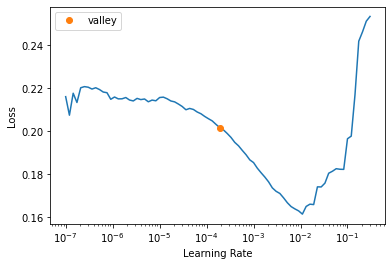

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.119636,58.924274,0.500000,0.500000,0.069231,0.121622,0.249691,01:15


Better model found at epoch 0 with f1_score value: 0.12162162162162163.


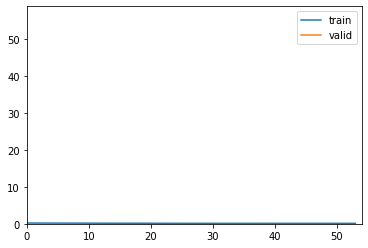

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.087936,0.068258,0.892308,0.898438,0.884615,0.891473,0.959435,01:15
1,0.077106,0.106793,0.891026,0.853828,0.943590,0.896468,0.948258,01:15
2,0.071662,0.075607,0.882051,0.951515,0.805128,0.872222,0.959589,01:14
3,0.066544,0.073228,0.889744,0.931818,0.841026,0.884097,0.960358,01:15
4,0.062888,0.067784,0.907692,0.914062,0.900000,0.906977,0.963097,01:15
5,0.058782,0.063383,0.915385,0.942623,0.884615,0.912698,0.967495,01:15
6,0.056540,0.073287,0.896154,0.909814,0.879487,0.894394,0.957702,01:15
7,0.053643,0.071040,0.892308,0.929775,0.848718,0.887399,0.958031,01:15
8,0.052068,0.124392,0.870513,0.950156,0.782051,0.857947,0.949878,01:15
9,0.051578,0.062206,0.902564,0.896465,0.910256,0.903308,0.967318,01:15


Better model found at epoch 0 with f1_score value: 0.8914728682170543.


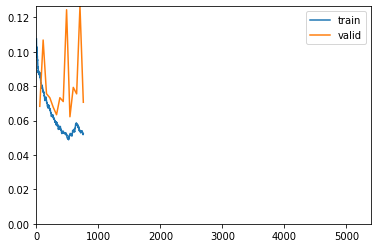

Better model found at epoch 1 with f1_score value: 0.8964677222898904.
Better model found at epoch 4 with f1_score value: 0.9069767441860466.
Better model found at epoch 5 with f1_score value: 0.9126984126984127.
No improvement since epoch 9: early stopping


In [15]:
learn.fine_tune(100,base_lr=3e-3)

In [16]:
dfTest = pd.read_csv('../testSample.csv')

In [17]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [18]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [19]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [20]:
learn.dls = dlsTest

In [21]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9589086127547666.


(#6) [0.0743996873497963,0.8984615206718445,0.92,0.8728205128205129,0.8957894736842105,0.9589086127547666]

# 384

In [7]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inceptionv4_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('inception_v4',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [11]:
learn.load('inceptionv4_224')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0002290867705596611)

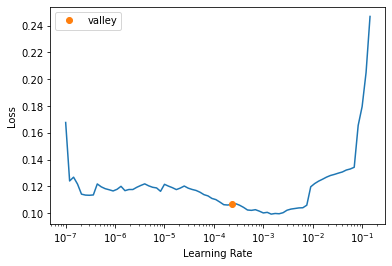

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.200499,6.221657,0.500000,0.500000,0.941026,0.653025,0.515289,02:06


Better model found at epoch 0 with f1_score value: 0.6530249110320284.


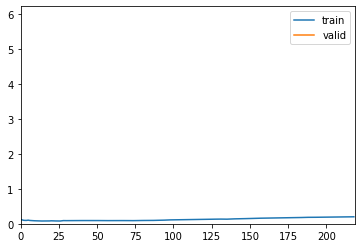

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.185952,0.196655,0.503846,0.534884,0.058974,0.106236,0.507498,02:06
1,0.184941,0.173626,0.503846,0.502052,0.941026,0.654773,0.537156,02:05
2,0.180854,0.174290,0.517949,0.510638,0.861538,0.641221,0.553376,02:04
3,0.177174,0.172148,0.551282,0.533333,0.820513,0.646465,0.558754,02:04
4,0.174057,0.173612,0.566667,0.545936,0.792308,0.646444,0.601759,02:04
5,0.170636,0.171786,0.593590,0.585882,0.638462,0.611043,0.605973,02:05
6,0.169372,0.167003,0.598718,0.565144,0.856410,0.680938,0.669573,02:04
7,0.164961,0.158403,0.658974,0.653465,0.676923,0.664987,0.704024,02:03
8,0.165058,0.156930,0.665385,0.656934,0.692308,0.674157,0.724352,02:05
9,0.162118,0.156922,0.684615,0.727848,0.589744,0.651558,0.727147,02:06


Better model found at epoch 0 with f1_score value: 0.10623556581986142.


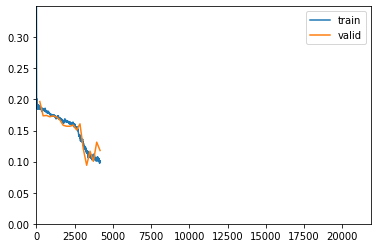

Better model found at epoch 1 with f1_score value: 0.6547725245316681.
Better model found at epoch 6 with f1_score value: 0.6809378185524974.
Better model found at epoch 13 with f1_score value: 0.7725321888412017.
Better model found at epoch 14 with f1_score value: 0.8351648351648352.
Better model found at epoch 16 with f1_score value: 0.8438709677419356.
No improvement since epoch 14: early stopping


In [13]:
learn.fine_tune(100,base_lr=6e-3)

In [14]:
dfTest = pd.read_csv('../testSample.csv')

In [15]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [17]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [18]:
learn.dls = dlsTest

In [19]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9027239973701512.


(#6) [0.10548856109380722,0.837948739528656,0.833164812942366,0.8451282051282051,0.8391038696537677,0.9027239973701512]

# 512

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inceptionv4_512',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('inception_v4',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('inceptionv4_384')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0010000000474974513)

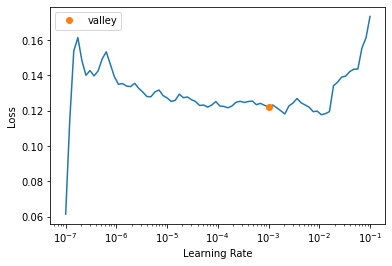

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.148717,0.135826,0.774359,0.763547,0.794872,0.778894,0.831055,04:46


Better model found at epoch 0 with f1_score value: 0.7788944723618091.


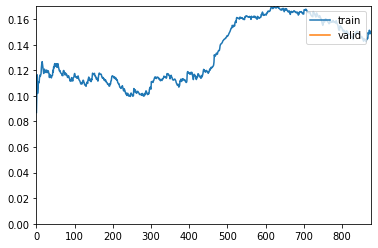

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.115394,0.094965,0.838462,0.885965,0.776923,0.827869,0.920999,04:50
1,0.113328,0.092378,0.838462,0.915094,0.746154,0.822034,0.933373,04:52
2,0.107316,0.095194,0.838462,0.945946,0.717949,0.816327,0.937827,04:53
3,0.108304,0.087492,0.861538,0.935185,0.776923,0.848739,0.941368,04:54
4,0.098299,0.087596,0.861538,0.932515,0.779487,0.849162,0.941667,04:54
5,0.099289,0.085231,0.867949,0.928358,0.797436,0.857931,0.943534,04:54
6,0.097032,0.088250,0.869231,0.926036,0.802564,0.859890,0.940273,04:53
7,0.103418,0.099455,0.817949,0.949275,0.671795,0.786787,0.935986,04:49
8,0.100894,0.081757,0.873077,0.926686,0.810256,0.864569,0.945043,04:49
9,0.115392,0.099443,0.848718,0.968966,0.720513,0.826471,0.947291,04:53


Better model found at epoch 0 with f1_score value: 0.8278688524590163.


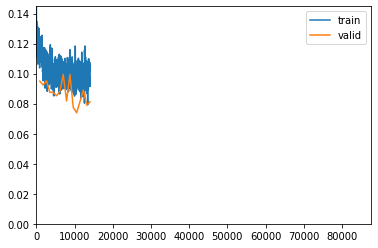

Better model found at epoch 3 with f1_score value: 0.8487394957983193.
Better model found at epoch 4 with f1_score value: 0.8491620111731845.
Better model found at epoch 5 with f1_score value: 0.8579310344827588.
Better model found at epoch 6 with f1_score value: 0.8598901098901099.
Better model found at epoch 8 with f1_score value: 0.8645690834473325.
Better model found at epoch 10 with f1_score value: 0.8888888888888887.
Better model found at epoch 14 with f1_score value: 0.8909825033647375.
No improvement since epoch 11: early stopping


In [12]:
learn.fine_tune(100,base_lr=3e-3)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9413622616699541.


(#6) [0.0837126150727272,0.8779487013816833,0.9126539753639418,0.8358974358974359,0.8725910064239828,0.9413622616699541]

In [ ]:
preds,y=learn.tta()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
import numpy as np

In [ ]:
np.argmax(preds,axis=1)

In [ ]:
f1_score(np.argmax(preds,axis=1),y)

In [ ]:
precision_score(np.argmax(preds,axis=1),y)

In [ ]:
recall_score(np.argmax(preds,axis=1),y)